In [8]:
%%time

#Import basic manipulation libraries 
import pandas as pd  
import numpy as np  

#importing plotting libraries
import matplotlib.pyplot as plt  
%matplotlib inline

#import AI libraries
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 

g = 0.1
N = 100
#Extract data in files
data_s = pd.read_csv('hollow.csv').values
data = data_s[1:,1:]


trainX, testX, trainY, testY = train_test_split(
    data[:,:4], data[:,4], test_size=0.33, random_state=42)

# Standarize X
scaler = StandardScaler()
scaler.fit(trainX)

# Apply aproximmative Kernel RBF  
rbf_feature = RBFSampler(gamma=g, n_components=N, random_state=1)
X_features = rbf_feature.fit_transform(scaler.transform(trainX))

#X_features = rbf_feature.fit_transform(trainX)

# Standarize the new kernel features
scaler = StandardScaler()
X_features = scaler.fit_transform(X_features)

lab_enc = LabelEncoder()
training_scores_encoded = lab_enc.fit_transform(trainY)

print("one down")

#tuned_parameters = [{'class_weight': [None,'balanced'], 'alpha': [1e-3, 1e-4], 'max_iter':[5,10]}]
tuned_parameters = [{'class_weight': [None], 'alpha': [1e-3,1e-4], 'max_iter':[5,10,20]}]

score = 'precision'

print("# Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(SGDClassifier(), tuned_parameters, cv=5,
                    scoring='%s_macro' % score)


clf.fit(X_features, training_scores_encoded)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"  %(mean, std * 2, params))
print()

    








one down
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'alpha': 0.0001, 'class_weight': None, 'max_iter': 20}

Grid scores on development set:

0.828 (+/-0.003) for {'alpha': 0.001, 'class_weight': None, 'max_iter': 5}
0.827 (+/-0.005) for {'alpha': 0.001, 'class_weight': None, 'max_iter': 10}
0.827 (+/-0.003) for {'alpha': 0.001, 'class_weight': None, 'max_iter': 20}
0.820 (+/-0.016) for {'alpha': 0.0001, 'class_weight': None, 'max_iter': 5}
0.827 (+/-0.007) for {'alpha': 0.0001, 'class_weight': None, 'max_iter': 10}
0.829 (+/-0.005) for {'alpha': 0.0001, 'class_weight': None, 'max_iter': 20}

Wall time: 9min 23s


In [9]:
#Preparando resultados


#Escalando Resultados
scale_Results = StandardScaler()
scale_Results.fit(testX)

# Apply aproximmative Kernel RBF  
XTEST_features = rbf_feature.fit_transform(scale_Results.transform(testX))

#Escalando el kernel
scale_Results2 = StandardScaler()
scale_Results2.fit(XTEST_features)


#print(XTEST_features.shape)
print(clf.decision_function(scale_Results2.transform(XTEST_features)))
YTEST = clf.predict(scale_Results2.transform(XTEST_features)) # estandarizado
#YTEST = clf.predict(XTEST_features) # NO estandarizado

lab_enc = LabelEncoder()
training_scores_encoded = lab_enc.fit_transform(testY)

#YTEST = clf.predict(scale_Results2.transform(XTEST_features))
print(confusion_matrix(training_scores_encoded,YTEST))  
print(classification_report(training_scores_encoded,YTEST)) 




[-1.02407146 -1.11734988 -0.912479   ... -1.10293934 -1.07967419
 -2.16293608]
[[918682  18317]
 [158410  76872]]
             precision    recall  f1-score   support

          0       0.85      0.98      0.91    936999
          1       0.81      0.33      0.47    235282

avg / total       0.84      0.85      0.82   1172281



In [10]:
#Import basic manipulation libraries 
import os
import nibabel as nib
import pandas as pd
import numpy as np

#import AI libraries
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA, KernelPCA

#import reporting tools
from sklearn.metrics import classification_report, confusion_matrix  

#importing data graphing libraries
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def getcut(data, index, col, mod='seg'):
    index = index % 210
    
    name = data.iat[index,0]
    name = '..\dataset\HGG\\' + name + '\\' + name + '_' + mod + '.nii.gz'
    
    
    value = data.iat[index, col]
    layer = data.iat[index,col]
    
    img = nib.load(name)
    cut = img.get_fdata()
    img.uncache()
    
    
    if(col == 1 or col == 'cor'):
        cut = cut[layer,:,:]
    elif(col == 2 or col == 'sag'):
        cut = cut[:,layer,:]
    elif(col == 3 or col == 'hor'):
        cut = cut[:,:,layer]
    else:
        cut = cut[layer,:,:]
    
    
    return cut

def extractPointsToDF(source, destination, index, col):
    """
    Extraer los puntos del corte designado de una MRI y agregarlos
    a el dataframe destination
    """
    
    T1 = getcut(source,index,col,mod='t1')
    T2 = getcut(source,index,col,mod='t2')
    T1C = getcut(source,index,col,mod='t1ce')
    FLAIR = getcut(source,index,col,mod='flair')
    RES = getcut(source,index,col)
    

    T1 = T1.flatten()
    T2 = T2.flatten()
    T1C = T1C.flatten()
    FLAIR = FLAIR.flatten()    
    RES = RES.flatten()
    

    
    name = [None]

    
    for i in range(T1.shape[0]):
         name.append(source.iat[index,0])
    
    name = name[1:]

    name = np.expand_dims(name, axis=0)
    T1 = np.expand_dims(T1, axis=0)
    T2 = np.expand_dims(T2, axis=0)
    T1C = np.expand_dims(T1C,axis=0)
    FLAIR = np.expand_dims(FLAIR,axis=0)
    RES = np.expand_dims(RES,axis=0)
    
    aux = np.concatenate((name,T1,T1C,T2,FLAIR,RES),axis=0)
    aux = np.transpose(aux)

  
    columns = ['NAME', 'T1','T1C','T2', 'FLAIR', 'RES']
    df = pd.DataFrame(data = aux, columns=columns)
    
    
    
    frames = [destination, df]
    destination = pd.concat(frames)
    
  
    
    return destination

def createPointsDF():
    columns = ['NAME', 'T1','T1C','T2', 'FLAIR', 'RES']
    df = pd.DataFrame(columns=columns)
    return df

def FullKernelReport(clf , kernel, base, img, dims2drop = ['NAME', 'RES'],   mod = 1, standarize = False):
    """
   Create a full report that includes:
    * PCA classification truth
    * PCA classification results
    * Ground truth segmentation
    * results segmentations
    * image in T1
    * sci-ki learn classification report
    
    Parameters:
        Clf: the already-trained SGD
        kernel: the already set kernel
        base: Dataframe of indexes of data. 
              Base must be loaded outside this function in order to make it faster, by only using it once.
        img: number of the image to take (int between 0 and 210)
        dims2drop = dimensions to analyze. This should be the same as training. By default we stay with 4 dimensions. 
        mod: perspective to use:
            0. Coronal
            1. Sagital 
            2. Horizontal
            Other: Would take coronal as default 
        standarize: if we want to also standarize data results. Default False
      
    """
    
    dataframe = createPointsDF() 
    
    #Evading to have wrong values of image perspective
    if(mod > 3 or mod < 1):
        mod = 1
    
    dataframe = extractPointsToDF(base,dataframe,img,mod)
    
    XTEST = dataframe.drop(dims2drop, axis = 1).values
    
    #creando el scaler antes de aplicar el kernel
    scaler = StandardScaler()
    scaler.fit(XTEST)
   
    X_features = kernel.fit_transform(scaler.transform(XTEST))
    
    #Verificando si el parametro de estandarizacion ha sido activado

    scaler = StandardScaler()
    scaler.fit(X_features)

    X_features = scaler.transform(X_features)
    
    #This is where the magic happens
    YPre = clf.predict(X_features)
    
    #extracting other values of interest
    YTEST = dataframe['RES'].values
    MRI =  dataframe['T1'].values
    
    
    print("Informe de clasificacion de la imagen " + str(img))
    #preparando resultados. 
    #Unificando las etiquetas de forma binaria, para hacerlo compatible al reporte de clasificacion.
    YTEST = YTEST.astype(float)
    YTEST[YTEST>0] = 1
    

    print(confusion_matrix(YTEST,YPre))  
    print(classification_report(YTEST,YPre)) 
    
    
    #WE OFFICIALY STAY PLOTTING!!
    %matplotlib inline
    f, axs = plt.subplots(3, 2, figsize=(7,12))
            
    #let's start with applying our PCA to overdimensioned data
    pca = PCA(n_components=2)
    pca.fit(X_features)
    space = pca.transform(X_features)
    
    #starting with scatter plots
    
    axs[0,0].scatter(space[:,0], space[:,1], c=YTEST, alpha=0.5)
    axs[0,0].set_title('Truth clasification', fontsize=15)
    
    axs[0,1].scatter(space[:,0], space[:,1], c=YPre, alpha=0.5)
    axs[0,1].set_title('Results clasification', fontsize=15)
    
    #reshaping everything in interesting values
    if (mod == 1 or mod == 2):
        MRI = MRI.reshape(240,155).astype(float)
        RES = YTEST.reshape(240,155).astype(float)
        YPre = YPre.reshape(240,155).astype(float)
    else:
        MRI = MRI.reshape(240,240).astype(float)
        RES = YTEST.reshape(240,240).astype(float)
        YPre = YPre.reshape(240,240).astype(float)
        
    axs[1,0].imshow(RES)
    axs[1,0].set_title('Truth image', fontsize=15)
    
    axs[1,1].imshow(YPre)
    axs[1,1].set_title('Predicted image', fontsize=15)
    
    axs[2,1].imshow(MRI)
    
    
    
    f.suptitle("differents results of image " + str(img),fontsize = 20)

    #f.tight_layout()
    plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Informe de clasificacion de la imagen 150
[[35823    35]
 [  316  1026]]
             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00     35858
        1.0       0.97      0.76      0.85      1342

avg / total       0.99      0.99      0.99     37200



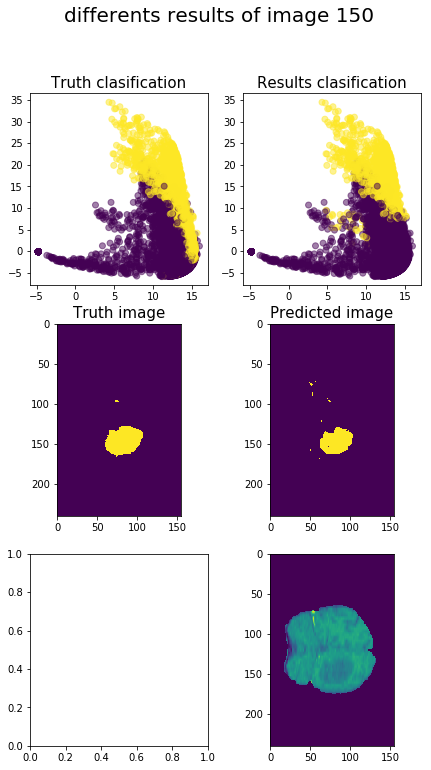

In [20]:
source = pd.read_csv('dataset.csv')
FullKernelReport(clf ,rbf_feature, source, 150,mod=2,standarize = False)

In [44]:
print(type(YTEST))

<class 'numpy.ndarray'>


In [ ]:
from __future__ import print_function


image_to_see = 18
peace = createPointsDF()
source = pd.read_csv('dataset.csv')
peace = extractPointsToDF(source,peace,image_to_see,2)

XTEST = peace.drop(['NAME','T2','RES'],axis = 1)
vistima = peace.drop(['NAME','T1C','FLAIR','T2','RES'],axis = 1)
res = peace['RES']




#Not standarized training / not standarizd test
#YIS = lolo.predict(XTEST)
#putis = YIS.reshape(240,155).astype(float)

#standarized training / not standarized test
Y = clf.predict(XTEST) #ESTANDAR
putisima = Y.reshape(240,155).astype(float) #NO ESTANDAR


#estandarized training / estandarized test

pute = StandardScaler()
pute.fit(XTEST)
YIS = clf.predict(pute.transform(XTEST))
putis = YIS.reshape(240,155).astype(float)


#creando grafica
import matplotlib.pyplot as plt
%matplotlib inline

"""
Old graph interface where function orientation was used

fig=plt.figure(figsize=(8,6))
fig.suptitle('Resultados imagen 194', fontsize=14)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=FIG_SIZE)

#NO ESTANDAR
img = putis
fig.add_subplot(221)
plt.imshow(img)


#ESTANDAR
img = putisima
fig.add_subplot(222)
plt.imshow(img)


#resultado
img = res.values.reshape(240,155).astype(float)
fig.add_subplot(223)
plt.imshow(img)

#img completa
img = vistima.values.reshape(240,155).astype(float)
fig.add_subplot(224)
plt.imshow(img)
plt.show()
"""


fig, axs = plt.subplots(1, 4, figsize=(12,7))

axs[0].imshow(putis)
axs[0].set_title('estandarized training \n estandarized test', fontsize=15)

axs[1].imshow(putisima)
axs[1].set_title('standarized training \n not standarized test', fontsize=15)

axs[2].imshow(res.values.reshape(240,155).astype(float))
axs[2].set_title('Ground Truth', fontsize=15)

axs[3].imshow(vistima.values.reshape(240,155).astype(float))
axs[3].set_title('T1 visualization', fontsize=15)

fig.suptitle("differents results of image " + str(image_to_see),fontsize = 20)

fig.tight_layout()
plt.show()